# Detecting Pneumonia using Chest X-Ray Images

## Dataset
### The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Complete problem statement and dataset is available on : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

## Loading required libraries

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import glob
import cv2
from skimage.io import imread
import keras
from keras.models import Model , Sequential
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.xception import Xception,preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.utils import np_utils
from keras.layers import Conv2D,Activation,MaxPooling2D,AveragePooling2D,BatchNormalization,Dropout,Dense,Flatten,Input
from keras.optimizers import Adam,RMSprop,SGD
from sklearn.metrics import confusion_matrix,precision_score,recall_score
from keras import backend as K
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Paths to directories
data_dir = Path('../input/chest_xray/chest_xray')

train = data_dir/'train'
val = data_dir/'val'
test = data_dir/'test'

### Preparing training data

In [3]:
normal_dir = train/'NORMAL'
pneumonia_dir = train/'PNEUMONIA'

normal = normal_dir.glob("*.jpeg")
pneumonia = pneumonia_dir.glob("*.jpeg")


train_data = []
X=[]
Y=[]

for img in normal:
    img = cv2.imread(str(img))
    img = cv2.resize(img,(229,229))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255
    label = np_utils.to_categorical(0,num_classes=2)
    train_data.append((img,0))
    X.append(img)
    Y.append(label)
    
for img in pneumonia:
    img = cv2.imread(str(img))
    img = cv2.resize(img,(229,229))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    label = np_utils.to_categorical(1,num_classes=2)
    img = img.astype(np.float32)/255
    train_data.append((img,1))
    X.append(img)
    Y.append(label)

train_data = pd.DataFrame(train_data,columns=['image','label'],index = None)  # converting to a dataframe
train_data = train_data.sample(frac=1.).reset_index(drop=True)                # shuffling the entries


train_data.head()
    


,image,label
0,"[[[0.84705883, 0.84705883, 0.84705883], [0.725...",1
1,"[[[0.21960784, 0.21960784, 0.21960784], [0.235...",0
2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",1
3,"[[[0.16862746, 0.16862746, 0.16862746], [0.2, ...",1
4,"[[[0.83137256, 0.83137256, 0.83137256], [0.854...",1


### Visualizing counts of Normal vs Pneumonia classes

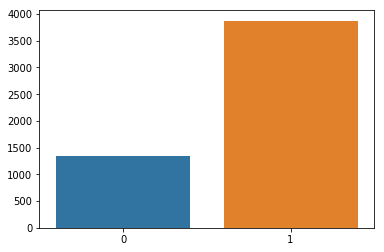

In [4]:
cases_count = train_data['label'].value_counts()
sns.barplot(cases_count.index,cases_count.values)

### Visulaizing the x-ray images of both the classes

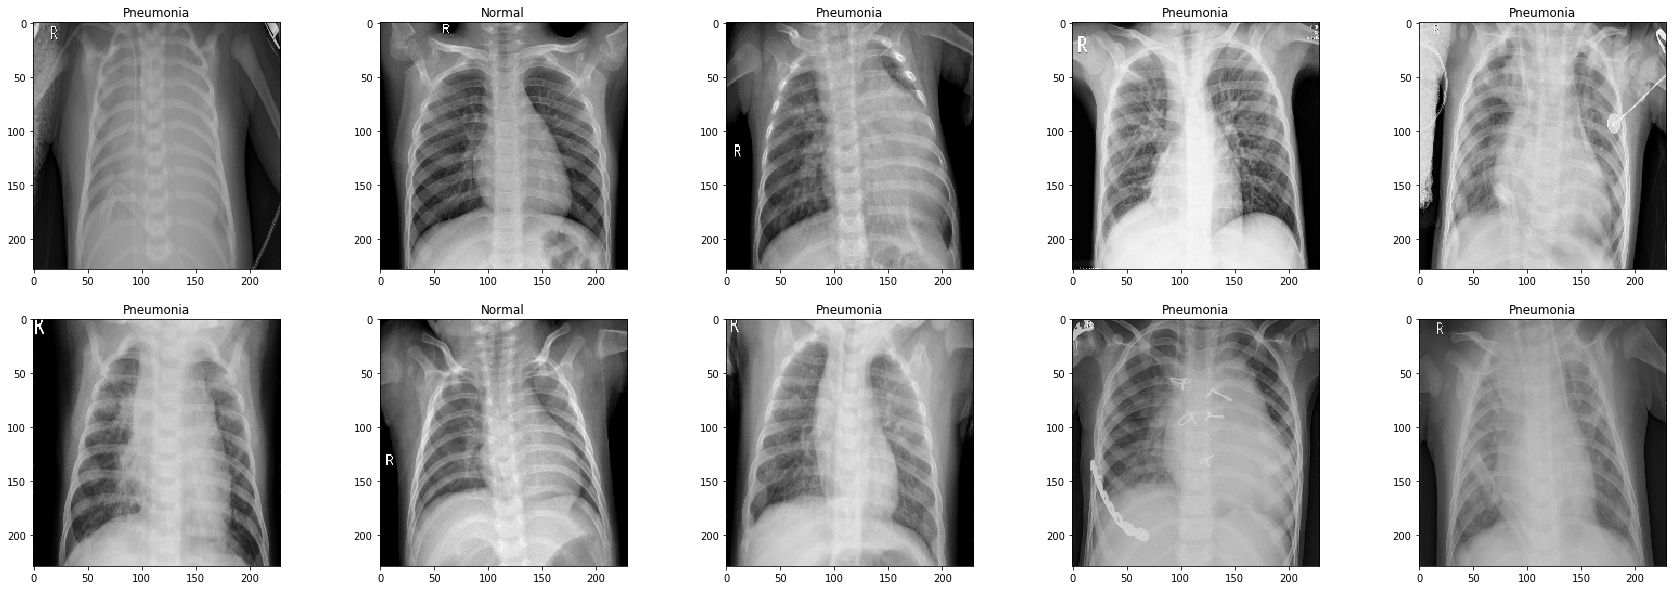

In [5]:
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    ax[i//5, i%5].imshow(train_data['image'][i], cmap='gray')
    if train_data['label'][i]==1:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
        
        

### Preparing validation data

In [6]:
normal_dir = val/'NORMAL'
pneumonia_dir = val/'PNEUMONIA'

normal = normal_dir.glob("*.jpeg")
pneumonia = pneumonia_dir.glob("*.jpeg")

val_x=[]
val_y=[]

for img in normal:
    img = cv2.imread(str(img))
    img = cv2.resize(img,(229,229))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255
    label = np_utils.to_categorical(0,num_classes=2)
    val_x.append(img)
    val_y.append(label)
    
    
for img in pneumonia:
    img = cv2.imread(str(img))
    img = cv2.resize(img,(229,229))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255
    label = np_utils.to_categorical(1,num_classes=2)
    val_x.append(img)
    val_y.append(label)

val_x = np.array(val_x)
val_y = np.array(val_y) 

print(val_x.shape)
print(val_y.shape)
    

(16, 229, 229, 3)
(16, 2)


### Preparing test data

In [7]:
normal_dir = test/'NORMAL'
pneumonia_dir = test/'PNEUMONIA'

normal = normal_dir.glob("*.jpeg")
pneumonia = pneumonia_dir.glob("*.jpeg")

test_x=[]
test_y=[]

for img in normal:
    img = cv2.imread(str(img))
    img = cv2.resize(img,(229,229))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255
    label = np_utils.to_categorical(0,num_classes=2)
    test_x.append(img)
    test_y.append(label)
    
    
for img in pneumonia:
    img = cv2.imread(str(img))
    img = cv2.resize(img,(229,229))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255
    label = np_utils.to_categorical(1,num_classes=2)
    test_x.append(img)
    test_y.append(label)

test_x = np.array(test_x)
test_y = np.array(test_y) 

print(test_x.shape)
print(test_y.shape)
    

(624, 229, 229, 3)
(624, 2)


In [8]:
X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(5216, 229, 229, 3)
(5216, 2)


# Transfer Learning

### Experimenting transfer learning with different models like Xception, InceptionV3 and VGG16. 

In [9]:
base_model = Xception(weights='imagenet',include_top = False,input_shape=(229,229,3))
#base_model = InceptionV3(weights='imagenet',include_top=False,input_shape=(229,229,3))
#base_model = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 229, 229, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 114, 114, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 114, 114, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 114, 114, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [ ]:
#for layer in base_model.layers:
    #layer.trainable = False

### Using Xception base model as feature extractor and building our own classifier on top of it according to our classification objective and dataset

In [11]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
#model.add(Dense(1024,activation='relu'))
#model.add(Dropout(0.7))
#model.add(Dense(512,activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 200706    
Total params: 21,062,186
Trainable params: 21,007,658
Non-trainable params: 54,528
_________________________________________________________________


### Using data augmentation to prevent overfitting and tackle the problem of imbalanced classes

In [13]:
data_generator = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,rotation_range=15,zoom_range=0.1)

In [14]:
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)

In [15]:
optimizer = Adam(lr=0.001,decay=1e-5)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['acc'])

In [27]:
batch_size = 32
epochs = 4
history = model.fit_generator(data_generator.flow(X,Y,batch_size = batch_size),steps_per_epoch = int(len(X)/batch_size),epochs=epochs,callbacks=[es,chkpt],validation_data=(val_x,val_y))
history

Epoch 1/4
163/163 [==============================] - 70s 431ms/step - loss: 0.0768 - acc: 0.9741 - val_loss: 0.8114 - val_acc: 0.6875
Epoch 2/4
163/163 [==============================] - 71s 434ms/step - loss: 0.0739 - acc: 0.9734 - val_loss: 0.5936 - val_acc: 0.6875
Epoch 3/4
163/163 [==============================] - 70s 428ms/step - loss: 0.0623 - acc: 0.9785 - val_loss: 0.1912 - val_acc: 0.9375
Epoch 4/4
163/163 [==============================] - 70s 430ms/step - loss: 0.0602 - acc: 0.9806 - val_loss: 0.5023 - val_acc: 0.6875


In [28]:
score = model.evaluate(test_x,test_y,verbose=0)
score

[0.35517746725907695, 0.8942307692307693]

### Xception model outperforms the other two models - InceptionV3 and VGG16 

In [29]:
y_pred = model.predict(test_x,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)

y_true = np.argmax(test_y,axis=-1)

In [30]:
print(confusion_matrix(y_true,y_pred))
print('Precision is {:.2f}'.format(precision_score(y_true,y_pred)))
print('Recall is {:.2f}'.format(recall_score(y_true,y_pred)))

[[183  51]
 [ 15 375]]
Precision is 0.88
Recall is 0.96


## Conclusion

Although the Imagenet dataset on which our base model was trained on is completely different from the chest x-ray image dataset , we are able to achieve a high recall score(desirable in medical diagnosis problems) via transfer learning with Xception model. 

Therefore considering the fact that there is a dearth of clean labeled medical image data and even after acquiring such data, it would be take a lot of computational power and time to train models for medical diagonis from scratch, transfer learning offers a great tool that can be used to assist professionals in healthcare and promote better diagnosis of serious health issues.

### Citations and helpful resources:
1. https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5
2. http://openaccess.thecvf.com/content_cvpr_2017/papers/Chollet_Xception_Deep_Learning_CVPR_2017_paper.pdf